# Model Evaluation

In [1]:
!pip install transformers --quiet
!pip install datasets --quiet
!pip install sentencepiece --quiet
!pip install torch --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 93.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 107.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 kB 35.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 71.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 kB 28.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 kB 28.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 57.6 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from transformers import MBartForConditionalGeneration, MBartTokenizer, MBart50TokenizerFast
from transformers import M2M100ForConditionalGeneration, M2M100Tokenizer

from datasets import load_dataset
import pandas as pd
import nltk
import copy

In [4]:
%%capture
sw_test_flores = load_dataset("facebook/flores", 'swh_Latn')
en_test_flores = load_dataset("facebook/flores", 'eng_Latn')

src_eval_texts = sw_test_flores['dev']['sentence'] + sw_test_flores['devtest']['sentence']
tgt_eval_texts = en_test_flores['dev']['sentence'] + en_test_flores['devtest']['sentence']

src_lang, tgt_lang = 'sw_KE', 'en_XX'

In [5]:
%%capture
# baseline_model = MBartForConditionalGeneration.from_pretrained("facebook/mbart-large-50-many-to-many-mmt")
tokenizer = MBart50TokenizerFast.from_pretrained("facebook/mbart-large-50-many-to-many-mmt", src_lang="sw_KE", tgt_lang="en_XX")

## Model Evaluation

In [6]:
import torch
from torch.utils.data import Dataset, DataLoader
import nltk.translate.bleu_score

class EvalDataset(Dataset):
    def __init__(self, src_eval_texts, tokenizer, src_lang):
        self.src_eval_texts = src_eval_texts
        self.tokenizer = tokenizer
        self.src_lang = src_lang

    def __len__(self):
        return len(self.src_eval_texts)

    def __getitem__(self, idx):
        self.tokenizer.src_lang = self.src_lang
        src_eval_texts = self.src_eval_texts[idx]
        # inputs = self.tokenizer(self.src_eval_texts[idx], return_tensors="pt", padding='max_length', max_length=32, truncation=True)

        return src_eval_texts

def evaluate_model(src_eval_texts, tgt_eval_texts, src_lang, tgt_lang, model, tokenizer, batch_size=16, device='cuda'):
    if torch.cuda.is_available() and device == 'cuda':
        device = torch.device('cuda')
        model.to(device)
        print('on gpu')
    else:
        device = torch.device('cpu')
        print('on cpu')

    eval_dataset = EvalDataset(src_eval_texts, tokenizer, src_lang)
    eval_dataloader = DataLoader(eval_dataset, batch_size=batch_size)

    model.eval()
    predicted = []
    nltk_bleu_scores = []

    with torch.no_grad():
        evaluated = 0
        for batch_idx, src_eval_texts in enumerate(eval_dataloader):
            # print(inputs)
            inputs = tokenizer(src_eval_texts, return_tensors="pt", padding='max_length', max_length=32, truncation=True)
            inputs = {k: v.to(device) for k, v in inputs.items()}
            # inputs = {k: v[0] for k, v in inputs.items()}
            # print(inputs)
            # print(len(inputs))
            translated_tokens = model.generate(**inputs, forced_bos_token_id=tokenizer.lang_code_to_id[tgt_lang])
            outputs = tokenizer.batch_decode(translated_tokens, skip_special_tokens=True)

            for i, output in enumerate(outputs):
                tgt_idx = batch_idx * batch_size + i
                predicted.append(output)
                BLEUscore = nltk.translate.bleu_score.sentence_bleu([tgt_eval_texts[tgt_idx].split()], output.split())
                nltk_bleu_scores.append(BLEUscore)
            evaluated += batch_size
            print('evaluated: ',evaluated)
    return predicted, nltk_bleu_scores


In [7]:
def evaluate_pipeline(src_eval_texts, tgt_eval_texts, model_path, tokenizer, model_type):

  model = MBartForConditionalGeneration.from_pretrained(model_path)
  print('model loaded')
  if 'facebook' in model_path:
    datasize = ''
  else:
    datasize = model_path.split('_')[-2]
  print(datasize)
  print(model_type)
  predicted, nltk_bleu_scores = evaluate_model(src_eval_texts, tgt_eval_texts, src_lang, tgt_lang, model, tokenizer)
  results = pd.DataFrame([src_eval_texts, tgt_eval_texts, predicted, nltk_bleu_scores]).T
  results.columns = ['source', 'target', 'predicted', 'bleu']
  results.to_csv(f'/content/drive/MyDrive/W266 Final Project/{model_type}_results_{datasize}.csv')
  return results


## Single Output

In [ ]:
# baseline_model.to('cpu')
# sw_sentence = 'Mnamo Jumatatu, wanasayansi kutoka Shule ya Tiba ya Chuo Kikuu cha Stanford walitangaza uvumbuzi wa kifaa kipya cha utambuzi ambacho kinaweza kupanga seli kwa aina: kidude kidogo kinachoweza kuchapwa, na ambacho kinaweza kutengenezwa kwa kutumia printa ya kawaida ya kupuliza rangi, yawezekana kwa takribani senti moja ya Marekani kwa kila moja.'

# inputs = tokenizer(sw_sentence, return_tensors="pt", padding='max_length', max_length=32, truncation=True)

# translated_tokens = baseline_model.generate(**inputs, forced_bos_token_id=tokenizer.lang_code_to_id[tgt_lang])
# outputs = tokenizer.batch_decode(translated_tokens, skip_special_tokens=True)
# outputs

# sw_sentence = 'Al Gore na Jenerali Tommy Franks kwa kawaida walinjuga mbali vichwa vya habari (Gore alijipata kwenye vichwa vya habari wakati Onion aliripoti kuwa yeye na Tipper walishiriki ngono baada ya kushindwa kwenye uchaguzi wa chuo).'

# inputs = tokenizer(sw_sentence, return_tensors="pt", padding='max_length', max_length=32, truncation=True)

# translated_tokens = baseline_model.generate(**inputs, forced_bos_token_id=tokenizer.lang_code_to_id[tgt_lang])
# outputs = tokenizer.batch_decode(translated_tokens, skip_special_tokens=True)
# outputs

# Baseline Results

## Baseline Model

In [ ]:
baseline_model_path = "facebook/mbart-large-50-many-to-many-mmt"

baseline_results = evaluate_pipeline(src_eval_texts, tgt_eval_texts, baseline_model_path, tokenizer, 'baseline')

In [ ]:
baseline_results

,source,target,predicted,bleu
0,"Mnamo Jumatatu, wanasayansi kutoka Shule ya Ti...","On Monday, scientists from the Stanford Univer...",We had hundreds of people from all over the wo...,0.0
1,Watafiti wakuu wanasema hili linaweza kuleta u...,Lead researchers say this may bring early dete...,The last thing I heard about my month was some...,0.0
2,JAS 39C Gripen ilianguka kwenye barabara kuu k...,The JAS 39C Gripen crashed onto a runway at ar...,JAS 39C The JAS 39C Gripen was caught on a sin...,0.101452
3,Rubani alitambuliwa kama Kiongozi wa Kikosi Di...,The pilot was identified as Squadron Leader Di...,Rubani is also found in the daytime fruits of ...,0.0
4,Vyombo vya habari vya ndani vinaripoti kwamba ...,Local media reports an airport fire vehicle ro...,Production and distribution of wines and spiri...,0
...,...,...,...,...
2004,Kwa kuwa maeneo hayo hayana idadi kubwa ya wat...,"As the areas are sparsely populated, and light...","In addition to non-Arabic languages, Arabic-sp...",0.0
2005,Desturi ya kazi ya Kijapani ni ya kimfumo na r...,Japanese work culture is more hierarchical and...,The thrill of casinos in Japan is not just a s...,0.0
2006,"Suti ni mavazi ya kawaida ya kibiashara, na wa...","Suits are standard business attire, and cowork...","It's not a waste of time to wash your kidneys,...",0.0
2007,"Ulinganifu katika mahali pa kazi ni muhimu, ku...","Workplace harmony is crucial, emphasizing grou...",Using the same in the mornings and evenings of...,0.0


In [ ]:
baseline_results['bleu'].mean()

0.004043805168329893

In [ ]:
# previous results
baseline_results['bleu'].mean()

0.004043805168329893

In [ ]:
# previous results
baseline_results.head()

,source,target,predicted,bleu
0,"Mnamo Jumatatu, wanasayansi kutoka Shule ya Ti...","On Monday, scientists from the Stanford Univer...",We had hundreds of people from all over the wo...,0.0
1,Watafiti wakuu wanasema hili linaweza kuleta u...,Lead researchers say this may bring early dete...,The last thing I heard about my month was some...,0.0
2,JAS 39C Gripen ilianguka kwenye barabara kuu k...,The JAS 39C Gripen crashed onto a runway at ar...,JAS 39C The JAS 39C Gripen was caught on a sin...,0.101452
3,Rubani alitambuliwa kama Kiongozi wa Kikosi Di...,The pilot was identified as Squadron Leader Di...,Rubani is also found in the daytime fruits of ...,0.0
4,Vyombo vya habari vya ndani vinaripoti kwamba ...,Local media reports an airport fire vehicle ro...,Production and distribution of wines and spiri...,0


,0
0,6.136171
1,9.948806
2,9.170411
3,10.657701
4,10.382888


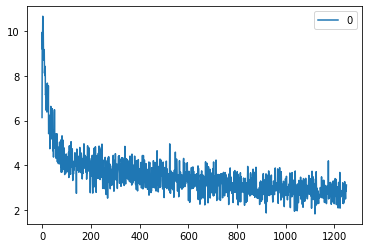

In [ ]:
losses = pd.read_csv('/content/drive/MyDrive/W266 Final Project/google_translate_5k_losses.csv').T.iloc[1:]
losses.plot()
losses.head()

## Google Translate

In [6]:
# export evaluation data to csv then to google sheets
# use google translate in sheets to translate 2000 swahili sentences
# evaluate bleu scores and save results to drive


evaluation_df = pd.DataFrame([src_eval_texts, tgt_eval_texts]).T
evaluation_df.columns = ['src_eval_text', 'tgt_eval_text']
evaluation_df.to_csv('/content/drive/MyDrive/W266 Final Project/evaluation_dataset.csv')

In [ ]:
gt_baseline_results = pd.read_csv('/content/drive/MyDrive/W266 Final Project/gt_baseline_results.csv')
gt_bleu_scores = []
for i in range(len(gt_baseline_results)):
    reference = gt_baseline_results['tgt_eval_text'][i]
    candidate = gt_baseline_results['google_translate'][i]
    reference_tokens = reference.split()
    candidate_tokens = candidate.split()
    bleu_score = nltk.translate.bleu_score.sentence_bleu([reference_tokens], candidate_tokens)
    gt_bleu_scores.append(bleu_score)

# Add the BLEU scores to the dataframe
gt_baseline_results['bleu'] = gt_bleu_scores
gt_baseline_results.to_csv('/content/drive/MyDrive/W266 Final Project/gt_baseline_results.csv')

In [ ]:
gt_baseline_results['bleu'].mean()

0.34630482361753534

## M2M-100

In [ ]:
from transformers import M2M100ForConditionalGeneration, M2M100Tokenizer


m2m_model = M2M100ForConditionalGeneration.from_pretrained("facebook/m2m100_418M")
m2m_tokenizer = M2M100Tokenizer.from_pretrained("facebook/m2m100_418M")

In [ ]:
m2m_predicted, m2m_nltk_bleu_scores = evaluate_model(src_eval_texts, tgt_eval_texts, 'sw', 'en', m2m_model, m2m_tokenizer)

In [13]:
m2m_results = pd.DataFrame([src_eval_texts, tgt_eval_texts, m2m_predicted, m2m_nltk_bleu_scores]).T
m2m_results.columns = ['source', 'target', 'predicted', 'bleu']
m2m_results.to_csv(f'/content/drive/MyDrive/W266 Final Project/m2m_baseline_results.csv')

In [9]:
m2m_results = pd.read_csv('/content/drive/MyDrive/W266 Final Project/m2m_baseline_results.csv')
m2m_results['bleu'].mean()

0.13528901161572715

## ChatGPT

In [ ]:
# use the google sheets from above, use ChatGPT api to translate the 2000 swahili sentences
# evaluate bleu scores and save results to drive

gpt_baseline_results = pd.read_csv('/content/drive/MyDrive/W266 Final Project/gpt_baseline_results.csv')
gpt_bleu_scores = []
for i in range(len(gpt_baseline_results)):
    reference = gpt_baseline_results['tgt_eval_text'][i]
    candidate = gpt_baseline_results['chatgpt'][i]
    reference_tokens = reference.split()
    candidate_tokens = candidate.split()
    bleu_score = nltk.translate.bleu_score.sentence_bleu([reference_tokens], candidate_tokens)
    gpt_bleu_scores.append(bleu_score)

# Add the BLEU scores to the dataframe
gpt_baseline_results['bleu'] = gpt_bleu_scores
gpt_baseline_results.to_csv('/content/drive/MyDrive/W266 Final Project/gpt_baseline_results.csv')


In [ ]:
gpt_baseline_results['bleu'].mean()

0.2528689870955184

# Google Translate Models

## 10K Model

In [ ]:
model_path_10k = "/content/drive/MyDrive/W266 Final Project/google_translate_mbart_sw_en_10k_model"
results_10k = evaluate_pipeline(src_eval_texts, tgt_eval_texts, model_path_10k, tokenizer)

In [ ]:
results_10k['bleu'].mean()

0.0038130563513374995

##20K Model

In [ ]:
model_path_20k = "/content/drive/MyDrive/W266 Final Project/google_translate_mbart_sw_en_20k_model"
results_20k = evaluate_pipeline(src_eval_texts, tgt_eval_texts, model_path_20k, tokenizer)

In [ ]:
results_20k['bleu'].mean()

0.017087657111397196

## 50K Model

In [ ]:
model_path_50k = "/content/drive/MyDrive/W266 Final Project/google_translate_mbart_sw_en_50k_model"
results_50k = evaluate_pipeline(src_eval_texts, tgt_eval_texts, model_path_50k, tokenizer)

In [ ]:
results_50k = pd.read_csv('/content/drive/MyDrive/W266 Final Project/google_translate_results_50k.csv')
results_50k

,Unnamed: 0,source,target,predicted,bleu
0,0,"Mnamo Jumatatu, wanasayansi kutoka Shule ya Ti...","On Monday, scientists from the Stanford Univer...","Earlier on Monday, scientists from the Univers...",8.735951e-02
1,1,Watafiti wakuu wanasema hili linaweza kuleta u...,Lead researchers say this may bring early dete...,Heads of researchers say this could bring abou...,1.445541e-78
2,2,JAS 39C Gripen ilianguka kwenye barabara kuu k...,The JAS 39C Gripen crashed onto a runway at ar...,JASras 39C Grip collapsed on the main road nea...,4.271302e-155
3,3,Rubani alitambuliwa kama Kiongozi wa Kikosi Di...,The pilot was identified as Squadron Leader Di...,Rubani was recognized as a military leader Dil...,7.241926e-155
4,4,Vyombo vya habari vya ndani vinaripoti kwamba ...,Local media reports an airport fire vehicle ro...,Internal information reports reports reports t...,1.024491e-231
...,...,...,...,...,...
2004,2004,Kwa kuwa maeneo hayo hayana idadi kubwa ya wat...,"As the areas are sparsely populated, and light...",Since these areas do not have a large number o...,3.127937e-01
2005,2005,Desturi ya kazi ya Kijapani ni ya kimfumo na r...,Japanese work culture is more hierarchical and...,Deutsche Welle Privacy Policy Legal Communicat...,0.000000e+00
2006,2006,"Suti ni mavazi ya kawaida ya kibiashara, na wa...","Suits are standard business attire, and cowork...","Suti is usually a businessman, and workers of ...",5.186904e-155
2007,2007,"Ulinganifu katika mahali pa kazi ni muhimu, ku...","Workplace harmony is crucial, emphasizing grou...",Comparison of qualifications in work place is ...,1.100888e-231


In [ ]:
results_50k['bleu'].mean()

0.0676905331389594

## 100k Model

In [ ]:
model_path_100k = "/content/drive/MyDrive/W266 Final Project/google_translate_mbart_sw_en_100k_model"
results_100k = evaluate_pipeline(src_eval_texts, tgt_eval_texts, model_path_100k, tokenizer)

In [ ]:
results_100k['bleu'].mean()

0.11457064080741951

## 200K Model

In [ ]:
model_path_200k = "/content/drive/MyDrive/W266 Final Project/google_translate_mbart_sw_en_200k_model"
results_200k = evaluate_pipeline(src_eval_texts, tgt_eval_texts, model_path_200k, tokenizer)

In [ ]:
results_200k['bleu'].mean()

0.14034984867804784

# ChatGPT Models

## 10K Model

In [ ]:
gpt_model_path_10k = "/content/drive/MyDrive/W266 Final Project/gpt_mbart_sw_en_10k_model"
gpt_results_10k = evaluate_pipeline(src_eval_texts, tgt_eval_texts, gpt_model_path_10k, tokenizer, 'gpt')

In [ ]:
gpt_results_10k['bleu'].mean()

2.0924734389530143e-81

## 20K Model

In [ ]:
gpt_model_path_20k = "/content/drive/MyDrive/W266 Final Project/gpt_mbart_sw_en_20k_model"
gpt_results_20k = evaluate_pipeline(src_eval_texts, tgt_eval_texts, gpt_model_path_20k, tokenizer, 'gpt')

In [ ]:
gpt_results_20k['bleu'].mean()

7.412291618668338e-05

## 50K Model

In [ ]:
gpt_model_path_50k = "/content/drive/MyDrive/W266 Final Project/gpt_mbart_sw_en_50k_model"
gpt_results_50k = evaluate_pipeline(src_eval_texts, tgt_eval_texts, gpt_model_path_50k, tokenizer, 'gpt')

In [ ]:
gpt_results_50k['bleu'].mean()

0.06628730284297797

## 100K Model

In [ ]:
gpt_model_path_100k = "/content/drive/MyDrive/W266 Final Project/gpt_mbart_sw_en_100k_model"
gpt_results_100k = evaluate_pipeline(src_eval_texts, tgt_eval_texts, gpt_model_path_100k, tokenizer, 'gpt')

In [ ]:
gpt_results_100k['bleu'].mean()

0.09321313410895621


## 2nd Half 50K Model

In [ ]:
gpt_model_path_last50k = "/content/drive/MyDrive/W266 Final Project/gpt_last_50k_mbart_sw_en_last50k_model"
gpt_results_last_50k = evaluate_pipeline(src_eval_texts, tgt_eval_texts, gpt_model_path_last50k, tokenizer, 'gpt_last_50k')

In [ ]:
gpt_results_last_50k['bleu'].mean()

1.8261764678529735e-81

# Reworded ChatGPT Models

## 10K Model

In [ ]:
rw_gpt_model_path_10k = "/content/drive/MyDrive/W266 Final Project/rw_mbart_sw_en_10k_model"
rw_gpt_results_10k = evaluate_pipeline(src_eval_texts, tgt_eval_texts, rw_gpt_model_path_10k, tokenizer, 'rw_gpt')

In [15]:
rw_gpt_results_10k['bleu'].mean()

1.9787715457557283e-81

## 20K Model

In [ ]:
rw_gpt_model_path_20k = "/content/drive/MyDrive/W266 Final Project/rw_mbart_sw_en_50k_model"
rw_gpt_results_20k = evaluate_pipeline(src_eval_texts, tgt_eval_texts, rw_gpt_model_path_20k, tokenizer, 'rw_gpt')

In [17]:
rw_gpt_results_20k['bleu'].mean()

0.00797290055600956

## 50K Model

In [ ]:
rw_gpt_model_path_50k = "/content/drive/MyDrive/W266 Final Project/rw_mbart_sw_en_20k_model"
rw_gpt_results_50k = evaluate_pipeline(src_eval_texts, tgt_eval_texts, rw_gpt_model_path_50k, tokenizer, 'rw_gpt')

In [19]:
rw_gpt_results_50k['bleu'].mean()

0.003574726672587716

## 100K Model

In [ ]:
rw_gpt_model_path_100k = "/content/drive/MyDrive/W266 Final Project/rw_mbart_sw_en_100k_model"
rw_gpt_results_100k = evaluate_pipeline(src_eval_texts, tgt_eval_texts, rw_gpt_model_path_100k, tokenizer, 'rw_gpt')

In [21]:
rw_gpt_results_100k['bleu'].mean()

0.009993819677246777

# M2M-100 Models

## 10K Model

In [ ]:
m2m_model_path_10k = "/content/drive/MyDrive/W266 Final Project/m2m_mbart_sw_en_10k_model"

m2m_results_10k = evaluate_pipeline(src_eval_texts, tgt_eval_texts, m2m_model_path_10k, tokenizer, 'm2m')

In [ ]:
results_10k['bleu'].mean()

2.1561104010862024e-81

## 20K Model

In [ ]:
m2m_model_path_20k = "/content/drive/MyDrive/W266 Final Project/m2m_mbart_sw_en_20k_model"
m2m_results_20k = evaluate_pipeline(src_eval_texts, tgt_eval_texts, m2m_model_path_20k, tokenizer, 'm2m')

In [ ]:
m2m_results_20k['bleu'].mean()

3.0325209315335096e-05

## 50K Model

In [ ]:
m2m_model_path_50k = "/content/drive/MyDrive/W266 Final Project/m2m_mbart_sw_en_50k_model"
m2m_results_50k = evaluate_pipeline(src_eval_texts, tgt_eval_texts, m2m_model_path_50k, tokenizer, 'm2m')

In [ ]:
m2m_results_50k['bleu'].mean()

4.3246481865796334e-05

## 100K Model

In [ ]:
m2m_model_path_100k = "/content/drive/MyDrive/W266 Final Project/m2m_mbart_sw_en_100k_model"
m2m_results_100k = evaluate_pipeline(src_eval_texts, tgt_eval_texts, m2m_model_path_100k, tokenizer, 'm2m')

In [ ]:
m2m_results_100k['bleu'].mean()

0.070774173431499

## 200K Model

In [ ]:
m2m_model_path_200k = "/content/drive/MyDrive/W266 Final Project/m2m_mbart_sw_en_200k_model"
m2m_results_200k = evaluate_pipeline(src_eval_texts, tgt_eval_texts, m2m_model_path_200k, tokenizer, 'm2m')

In [ ]:
m2m_results_200k['bleu'].mean()

0.08554327098295447

# mBART Models

## 10K Model

In [ ]:
mbart_model_path_10k = "/content/drive/MyDrive/W266 Final Project/mbart_mbart_sw_en_10k_model"
mbart_results_10k = evaluate_pipeline(src_eval_texts, tgt_eval_texts, mbart_model_path_10k, tokenizer, 'mbart')

In [ ]:
mbart_results_10k['bleu'].mean()

0.001725864548462383

## 20K Model

In [ ]:
mbart_model_path_20k = "/content/drive/MyDrive/W266 Final Project/mbart_mbart_sw_en_20k_model"
mbart_results_20k = evaluate_pipeline(src_eval_texts, tgt_eval_texts, mbart_model_path_20k, tokenizer, 'mbart')

In [ ]:
mbart_results_20k['bleu'].mean()

8.730156979570488e-157

## 50K Model

In [ ]:
mbart_model_path_50k = "/content/drive/MyDrive/W266 Final Project/mbart_mbart_sw_en_50k_model"
mbart_results_50k = evaluate_pipeline(src_eval_texts, tgt_eval_texts, mbart_model_path_50k, tokenizer, 'mbart')

In [ ]:
mbart_results_50k['bleu'].mean()

0.00037149514649936717

## 100K Model

In [ ]:
mbart_model_path_100k = "/content/drive/MyDrive/W266 Final Project/mbart_mbart_sw_en_100k_model"
mbart_results_100k = evaluate_pipeline(src_eval_texts, tgt_eval_texts, mbart_model_path_100k, tokenizer, 'mbart')

In [ ]:
mbart_results_100k['bleu'].mean()

0.000920760754856886

In [ ]:
mbart_results_100k = pd.read_csv('/content/drive/MyDrive/W266 Final Project/mbart_results_100k.csv')
mbart_results_100k

,Unnamed: 0,source,target,predicted,bleu
0,0,"Mnamo Jumatatu, wanasayansi kutoka Shule ya Ti...","On Monday, scientists from the Stanford Univer...",We're the world's largest emitter of greenhous...,2.749135e-232
1,1,Watafiti wakuu wanasema hili linaweza kuleta u...,Lead researchers say this may bring early dete...,You're going to hear about the latest news fro...,6.905801e-232
2,2,JAS 39C Gripen ilianguka kwenye barabara kuu k...,The JAS 39C Gripen crashed onto a runway at ar...,JAS 39C – The JAS 39C – The JAS 39C – The JAS ...,1.720882e-78
3,3,Rubani alitambuliwa kama Kiongozi wa Kikosi Di...,The pilot was identified as Squadron Leader Di...,Rubani is the world's largest exporter of dilo...,1.051835e-231
4,4,Vyombo vya habari vya ndani vinaripoti kwamba ...,Local media reports an airport fire vehicle ro...,You can see all of the world's wines from all ...,8.231055e-232
...,...,...,...,...,...
2004,2004,Kwa kuwa maeneo hayo hayana idadi kubwa ya wat...,"As the areas are sparsely populated, and light...",And you can see that every single day of your ...,7.992219e-232
2005,2005,Desturi ya kazi ya Kijapani ni ya kimfumo na r...,Japanese work culture is more hierarchical and...,The vast majority of the world's online casino...,8.412066e-232
2006,2006,"Suti ni mavazi ya kawaida ya kibiashara, na wa...","Suits are standard business attire, and cowork...","We're not just talking about the kibiashara, b...",8.614912e-232
2007,2007,"Ulinganifu katika mahali pa kazi ni muhimu, ku...","Workplace harmony is crucial, emphasizing grou...",I was able to match every single aspect of you...,0.000000e+00


## 200K Model

In [ ]:
mbart_model_path_200k = "/content/drive/MyDrive/W266 Final Project/mbart_mbart_sw_en_200k_model"
mbart_results_200k = evaluate_pipeline(src_eval_texts, tgt_eval_texts, mbart_model_path_200k, tokenizer, 'mbart')

In [ ]:
mbart_results_200k['bleu'].mean()

5.020190793008676e-05

In [ ]:
mbart_results_200k = pd.read_csv('/content/drive/MyDrive/W266 Final Project/mbart_results_200k.csv')
mbart_results_200k

,Unnamed: 0,source,target,predicted,bleu
0,0,"Mnamo Jumatatu, wanasayansi kutoka Shule ya Ti...","On Monday, scientists from the Stanford Univer...",You're going to be spending a lot of money on ...,5.214006e-232
1,1,Watafiti wakuu wanasema hili linaweza kuleta u...,Lead researchers say this may bring early dete...,You're going to be spending a lot of money on ...,6.685295e-232
2,2,JAS 39C Gripen ilianguka kwenye barabara kuu k...,The JAS 39C Gripen crashed onto a runway at ar...,You're going to be spending a lot of money on ...,9.472214e-232
3,3,Rubani alitambuliwa kama Kiongozi wa Kikosi Di...,The pilot was identified as Squadron Leader Di...,You'll be able to see all of the world's langu...,0.000000e+00
4,4,Vyombo vya habari vya ndani vinaripoti kwamba ...,Local media reports an airport fire vehicle ro...,You're going to be spending a lot of money on ...,0.000000e+00
...,...,...,...,...,...
2004,2004,Kwa kuwa maeneo hayo hayana idadi kubwa ya wat...,"As the areas are sparsely populated, and light...","Now, the U.S. was the world's second-largest e...",6.517294e-232
2005,2005,Desturi ya kazi ya Kijapani ni ya kimfumo na r...,Japanese work culture is more hierarchical and...,"Now, the U.S. was the world's second-largest e...",8.769105e-232
2006,2006,"Suti ni mavazi ya kawaida ya kibiashara, na wa...","Suits are standard business attire, and cowork...","Now, I'm going to show you some of the world's...",8.614912e-232
2007,2007,"Ulinganifu katika mahali pa kazi ni muhimu, ku...","Workplace harmony is crucial, emphasizing grou...",You're going to be spending a lot of money on ...,0.000000e+00


## 2nd 10K Dataset

In [ ]:
mbart_model_path_last_10k = "/content/drive/MyDrive/W266 Final Project/mbart_last_10k_mbart_sw_en_last10k_model"
mbart_results_last_10k = evaluate_pipeline(src_eval_texts, tgt_eval_texts, mbart_model_path_last_10k, tokenizer, 'mbart_last_10k')

In [ ]:
mbart_results_last_10k['bleu'].mean()

1.1152226474751814e-80

## 2nd 100K Dataset

In [ ]:
mbart_model_path_last_100k = "/content/drive/MyDrive/W266 Final Project/mbart_last_100k_mbart_sw_en_last100k_model"
mbart_results_last_100k = evaluate_pipeline(src_eval_texts, tgt_eval_texts, mbart_model_path_last_100k, tokenizer, 'mbart_last_100k')

In [ ]:
mbart_results_last_100k = pd.read_csv("/content/drive/MyDrive/W266 Final Project/mbart_last_100k_results_last100k.csv")

In [ ]:
mbart_results_last_100k['bleu'].mean()

0.0012300777010507092

In [ ]:
mbart_results_last_100k

,Unnamed: 0,source,target,predicted,bleu
0,0,"Mnamo Jumatatu, wanasayansi kutoka Shule ya Ti...","On Monday, scientists from the Stanford Univer...","We're the world's fastest growing nation, and ...",2.003844e-232
1,1,Watafiti wakuu wanasema hili linaweza kuleta u...,Lead researchers say this may bring early dete...,You're going to hear the entire language of th...,7.420766e-232
2,2,JAS 39C Gripen ilianguka kwenye barabara kuu k...,The JAS 39C Gripen crashed onto a runway at ar...,"JAS 39C Gripen is a six-month-long, six-month-...",8.187981e-79
3,3,Rubani alitambuliwa kama Kiongozi wa Kikosi Di...,The pilot was identified as Squadron Leader Di...,Rubani is an American who grew up in the Unite...,0.000000e+00
4,4,Vyombo vya habari vya ndani vinaripoti kwamba ...,Local media reports an airport fire vehicle ro...,All of the world's wines are covered by the wa...,0.000000e+00
...,...,...,...,...,...
2004,2004,Kwa kuwa maeneo hayo hayana idadi kubwa ya wat...,"As the areas are sparsely populated, and light...","Now, I'm not the only person in the entire wor...",1.136781e-231
2005,2005,Desturi ya kazi ya Kijapani ni ya kimfumo na r...,Japanese work culture is more hierarchical and...,The vast majority of the casinos in the United...,8.614912e-232
2006,2006,"Suti ni mavazi ya kawaida ya kibiashara, na wa...","Suits are standard business attire, and cowork...",You're not going to hear any of the world's la...,0.000000e+00
2007,2007,"Ulinganifu katika mahali pa kazi ni muhimu, ku...","Workplace harmony is crucial, emphasizing grou...",You can find out more about the history of onl...,0.000000e+00
